# Handout 1: Instance-based Learning (Problem 2)

### 0.1. Functions Definition

In this initial subsection, we will define the different functions that will be used.

In [1]:
import numpy as np
from numpy import array, dot
from qpsolvers import solve_qp
import matplotlib.pyplot as plt

#### Builders

The transformation function providad is: $\Phi(x_1, x_2)=(x_1x_2, x_1^2 + x_2^2)$

In [2]:
# Kernel function for the given phi transformation
def K_phi(x1, x2, z1, z2):
    k_result = x1*x2*z1*z2
    k_result = k_result + (pow(x1,2)*pow(z1,2) + pow(x1,2)*pow(z2,2) + pow(x2,2)*pow(z1,2) + pow(x2,2)*pow(z2,2))
    return k_result

In [3]:
def kernel(X, Z):
    gram_matrix = np.zeros((X.shape[0], Z.shape[0]))
    for i, x in enumerate(X):
        for j, z in enumerate(Z):
            x = x.flatten()
            z = z.flatten()
            k_result = x[0]*x[1]*z[0]*z[1]
            k_result = k_result + (pow(x[0],2)*pow(z[0],2) + pow(x[0],2)*pow(z[1],2) + pow(x[1],2)*pow(z[0],2) + pow(x[1],2)*pow(z[1],2))
            gram_matrix[i, j] = k_result
    return gram_matrix

In [4]:
def kernel2(X, Z):
    x1 = X[0]
    x2 = X[1]
    z1 = Z[0]
    z2 = Z[1]
    k_result = x1*x2*z1*z2
    k_result = k_result + (pow(x1,2)*pow(z1,2) + pow(x1,2)*pow(z2,2) + pow(x2,2)*pow(z1,2) + pow(x2,2)*pow(z2,2))
    return k_result

In [5]:
def customKernelGramMatrix(X1, X2, K_function=kernel2):
    """(Pre)calculates Gram Matrix K"""

    gram_matrix = np.zeros((X1.shape[0], X2.shape[0]))
    for i, x1 in enumerate(X1):
        for j, x2 in enumerate(X2):
            gram_matrix[i, j] = K_function(x1, x2)
    return gram_matrix

In [6]:
# Creates the H matrix 
def build_H(X, y):
    H = np.zeros((y.shape[0],y.shape[0]))
    for j in range(y.shape[0]):
        for i in range(y.shape[0]):
            if i != j:
                value = K_phi(X[i, 0], X[i, 1], X[j, 0], X[j, 1]) * np.dot(y[i], y[j]) # g(x)
                H[j, i] = value # symmetric
                H[i, j] = value # values
            else: # diagonal axis
                 H[j, j] = K_phi(X[j, 0], X[j, 1], X[j, 0], X[j, 1]) * np.dot(y[j], y[j]) # g(x)
    return H

The formulas for `w` and `w0` are:

$w= \sum_{i \mid \lambda_i \neq 0} \lambda_i y_i \Phi(x_i)$

$w_0= \frac{1}{N_\lambda}\sum_{i \mid \lambda_i \neq 0} (y_i - \sum_{j \mid \lambda_j \neq 0} \lambda_j y_j K(x_j, x_i))$

In [7]:
# Builds the weights w1 and w2
def build_w(X, y, idxs, lambdas):
    X_t = transform_data(X) # we need to transform the data with the phi function
    list_results = [] 
    for idx in idxs: # we use only lambdas = 1
        list_results.append((X_t[idx,]*y[idx,]*lambdas[idx,]))
    return sum(list_results)

# Builds the constant value w0
def build_w0(X, y, idxs, lambdas):
    result = 0
    for i in idxs: # we use only lambdas = 1
        sum_y = 0
        for j in idxs: # we use only lambdas = 1
            sum_y = lambdas[j]*y[j]*K_phi(X[i, 0], X[i, 1], X[j, 0], X[j, 1]) # we need to apply the kernel
        y_res = y[i] - sum_y
        result += y_res
    return result/len(lambdas)

# Computes w1, w2 and w0
def get_w_w0(X, y, idxs, lambdas):
    return build_w(X, y, idxs, lambdas), build_w0(X, y, idxs, lambdas)

The decision function is different depending on wether the data is transformed or not. If it is **transformed**, as the lambdas, weights and constant value were computed using the *transformed* values of the data, we simply apply the usual $g(x)$ function:

$g(x') = w_1x_1 + w_2x_2 + w_0$

If we are dealing with the *original* data, however, we have determine the decision function by using the $\Phi$ transformation function, as it was used in the computation of the values. Therefore, we have:

$\Phi(x_1, x_2) = (x_1x_2, x_1^2 + x_2^2)$

and the weights $w_1$ and $w_2$ are 

$w = (w_1, w_2)$

We have that the decision function is computed like so:

$g(x) = \Phi(x_1, x_2) \cdot w = (w_1, w_2) = x_1x_2w_1 + (x_1^2 + x_2^2)w_2$

In [8]:
# Computes a matrix of points using g(x)
def get_XX_YY_Z(w1, w2, w0, transformed=False,num_points=60):
    xlim = plt.gca().get_xlim()
    ylim = plt.gca().get_ylim()
    xx = np.linspace(xlim[0], xlim[1], num_points)
    yy = np.linspace(ylim[0], ylim[1], num_points)
    YY, XX = np.meshgrid(yy, xx)
    Z = np.zeros((num_points*num_points, 1))
    k = 0
    for x1 in xx:
        for x2 in yy:
            # if the data is transformed with the phi function, we compute the g(x) = w1*x1 + w2*x2 + w0
            if transformed: 
                Z[k] =  x1*w1 + x2*w2 + w0
            #if it's the original data points, we need to multiply the phi transformation function with w1 and w2
            else: 
                Z[k] =  x1*x2*w1 + (pow(x1,2) + pow(x2,2))*w2
            k += 1
    return YY, XX, Z

#### Plotters

`scatter_plot` plots the data points on the XY axis. Optionally, it can also plot the decision function's result if the `w`, `w0` and `hil` are given. 

In [9]:
# Plots the data points of each class; if provided, it will also plot the decision boundary
def scatter_plot(X,title, xlabel, ylabel, transformed=False, num_points=60, w1=None, w2=None,w0=None,hil=None, levels=[-1, 0, 1]):
    plt.figure(1)
    #plt.scatter(XP1[:,0],XP1[:,1], c=yP1)
    plt.scatter(X[np.where(y > 0)[0]][:,0], X[np.where(y > 0)[0]][:,1], marker='+', color= '#3CB371', label='class 1')
    plt.scatter(X[np.where(y < 0)[0]][:,0], X[np.where(y < 0)[0]][:,1], marker='*', color= '#FF4500', label='class 2')
    # Plot the hyperplane that separates the two classes 
    if hil is not None:
        ax = plt.gca()
        ax.scatter(X[hil,0],X[hil,1], s=100,linewidth=1, facecolors='none',
                  edgecolors='k', label="support vector")
        YY, XX, Z = get_XX_YY_Z(w1, w2, w0, transformed, num_points)
        # plot boundary of levels -1, 0 and 1
        ax.contour(XX,YY,Z.reshape(XX.shape), colors='k', levels=levels,
          alpha = 0.5,
          linestyles=['--','-','--'])  
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axis('equal')
    plt.legend()
    plt.title(title)
    plt.show(block=False)

In [10]:
# Plots the decision map of the model
def matrix_plot(X, w1, w2, w0, xlabel, ylabel, title, transformed=False, threshold=0, num_points=60):
    plt.figure(2)
    plt.scatter(X[np.where(y > 0)[0]][:,0], X[np.where(y > 0)[0]][:,1], marker='+', color= '#3CB371', label='class 1')
    plt.scatter(X[np.where(y < 0)[0]][:,0], X[np.where(y < 0)[0]][:,1], marker='*', color= '#FF4500', label='class 2')
    ax = plt.gca()
    YY, XX, Z = get_XX_YY_Z(w1, w2, w0, transformed, num_points)
    if transformed:
        C = np.where(Z > -2.9, 1, 0)
        plt.imshow(C.reshape(XX.shape).T, origin='lower', extent=(-1,1,-0.5,1.25), cmap='RdYlGn')
    else:
        C = np.where(Z > -2.2, 1, 0)
        plt.imshow(C.reshape(XX.shape).T, origin='lower', extent=(-1.2,1.2,-1.05,1.05), cmap='RdYlGn')
    
    plt.colorbar()
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_xlim())
    plt.axis('equal')
    plt.title(title)
    plt.show(block=False)

In [14]:
# Plots the decision function computed by a scikit SVM object
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
        
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    print(xy.shape)
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none', 
                  edgecolors='k', label='support vector');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.legend()

### 0.2. Data Loading and Pre-Processing

The data can be found in `datasets10/ds102.txt`. This file contains data points pertaining to two different classes.

In [13]:
group = '10'
ds = 2
data = np.loadtxt('datasets10/ds'+group+str(ds)+'.txt')
X = data[:, 0:2]
y = data[:, 2:3]
y = np.where(y == 0, -1, y) # replace 0 values with -1 

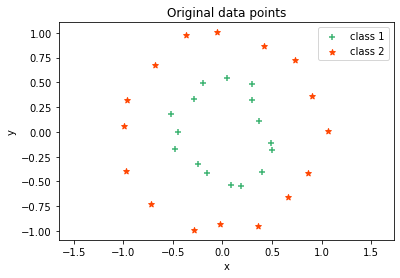

In [14]:
scatter_plot(X, 'Original data points', 'x', 'y')

We can see that the data is not linearly separable.

### **Problem 2**. Non-linear SVM.

The providad data is not linearly separable. In such cases, we need to apply a transformation function to the data that will either expand the space of the data, or will manipulate the data points. In this case, the transformation function we will use is:

$\Phi(x_1, x_2) = (x_1x_2, x_1^2 + x_2^2)$

In this case, we still keep the 2-dimensional data space, but we modify each component of the data points. 

In [15]:
# Transformation function for the data points
def transform_data(X):
    X_t = np.zeros((X.shape[0],X.shape[1]))
    for i in range(0, X.shape[0]):
        X_t[i,0] = X[i,0]*X[i,1]
        X_t[i,1] = pow(X[i,0],2)  + pow(X[i,1],2) 
    return X_t

Now, let's apply the transformation function and visualize the results:

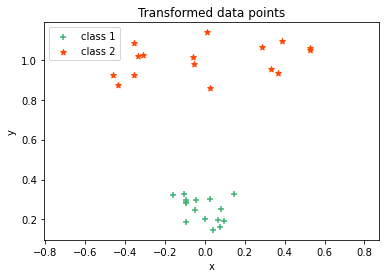

In [16]:
X_t = transform_data(X)
X_t
scatter_plot(X_t, 'Transformed data points', 'x', 'y')

We have managed to transform the original data so that it is linearly separable. Now, all the calculations will have to be made with this transformed data, and later on apply the obtained values to the original data. We will discuss this later on.

The important concept in this problem is the use of a **kernel** function that is used to transform the data and compute the necessary values ($\lambda_i, w_1, w_2, w_0$). The kernel function is computed through the $\Phi$ function.

$K(x,z) = \Phi(X) \cdot \Phi(Z) = (x_1x_2, x_1^2 + x_2^2) \cdot \left( \begin{array}{c} z_1z_2 \\ z_1^2 + z_2^2 \end{array} \right)$

Thus, we have that our kernel function is

$K(x,z) = x_1x_2z_1z_2 + x_1^2z_1^2 + x_1^2z_2^2 + x_2^2z_1^2 + x_2^2z_2^2$ 

The SVM algorithm in matrix notation for non-linear data is:

$HA + \mu Y - \Delta =$ **1**

$ A = \left[ \begin{array}{cc} \lambda_1 \\ \lambda_2 \\ \vdots \\ \lambda_N \end{array} \right],  \mbox{    }
Y = \left[ \begin{array}{cc|r} y_1 \\ y_2 \\ \vdots \\ y_N \end{array} \right], \mbox{    }
\Delta = \left[ \begin{array}{cc|r} \delta_1 \\ \delta_2 \\ \vdots \\ \delta_N \end{array} \right], \mbox{    }
1 = \left[ \begin{array}{cc|r} 1 \\ 1 \\ \vdots \\ 1 \end{array} \right]
$

$ H = \left[ \begin{array}{ccccc}
y_1y_1K(x_1,x_1) & y_1y_2K(x_1,x_2) & \dots & y_1y_NK(x_1,x_N) \\
y_2y_1K(x_2,x_1) & y_2y_2K(x_2,x_2) & \dots & y_2y_NK(x_2,x_N) \\
\vdots & \vdots & \ddots & \vdots \\ 
y_Ny_1K(x_N,x_1) & y_Ny_2K(x_N,x_2) & \dots & y_Ny_NK(x_N,x_N)
\end{array} \right]$

In order to compute support vectors, we need to calculate the $\lambda_i$ corresponding to each $X_i$. If $\lambda_i = 1$, it means that the corresponding $X_i$ is a support vector. 

First, we define the components:

In [19]:
N = y.shape[0] # total points in the data
y_reshape = y.reshape((N,))
P = build_H(X,y) # the H component
q = -np.ones((N,))
G = -np.identity(N)
h = np.zeros((N,)) 
A = y.reshape((1, -1)) # the Y component
b = np.zeros(1) # the 1 component

Now, we apply the quadratic solver and obtain the $A$ component, which contains the $\lambda_i$.

In [20]:
lm = solve_qp(P, q, G, h, A, b, solver = 'cvxopt') # compute the lambdas 
print(f"Lambdas values for each X component:\n\n {lm}")

Lambdas values for each X component:

 [8.91795712e-08 1.06361346e-07 1.56013366e-07 1.35247797e-07
 1.72677707e-07 2.56032266e-07 7.08737677e+00 1.82058600e-06
 1.27994783e-07 3.51019264e+00 4.82375649e-07 9.35238607e-08
 3.29646594e-07 7.62836870e-08 1.60848217e-07 1.66663659e-07
 1.27390446e-07 2.91394934e-07 1.03280490e-07 2.76697011e-07
 1.12024721e-07 7.45286164e-07 2.29770895e-07 6.06781331e-07
 1.29841638e-07 1.50989638e-07 4.12125824e-07 3.57718089e+00
 5.08339350e-07 1.18764300e-07 6.11471182e-07 3.39034949e-07]


Now, the lambdas need to be transformed so the values are either 0 or 1. The $\lambda_i = 1$ means that the corresponding $X_i$ is a *support vector*.

In [21]:
lm_aux = lm > 0.01 # threshold
lambdas = lm_aux.astype(int)
print(f"Support vectors: \n\n{X[np.where(lambdas==1)]}")

Support vectors: 

[[-0.02723471 -0.92663248]
 [ 0.30232016  0.48542418]
 [ 0.19164869 -0.54092909]]


Next, $w$ and $w0$ are computed.

In [22]:
w, w0 = get_w_w0(X, y, np.where(lambdas==1)[0], lm)
w

array([-0.03456843, -3.76477879])

In [23]:
w0

array([-0.02376109])

#### Transformed Data

The decision function for the *transformed* data that separates the two classes in the dataset is:

$g(x') = -0.03456843x_1 - 3.76477879x_2 - 0.02376109$

Finally, we plot the data points, the support vectors and the decision function.

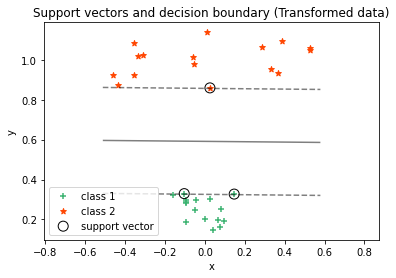

In [30]:
scatter_plot(X_t, "Support vectors and decision boundary (Transformed data)", "x", "y", transformed=True,w1=w[0], w2=w[1], w0=w0, hil=np.where(lambdas==1), levels =[-3.25, -2.25, -1.25])

Also the classification map. 

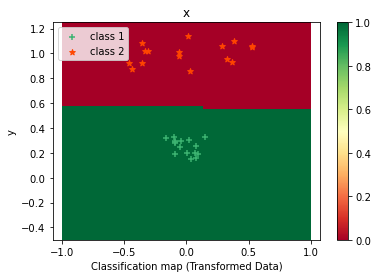

In [32]:
matrix_plot(X_t, w[0], w[1], w0, 'Classification map (Transformed Data)', 'y', 'x', transformed = True)

#### Original Data

The decision function for the *original* data that separates the two classes in the dataset is:

$g(x) = -0.03456843x_1x_2 - 3.76477879(x_1^2 + x_2^2)$

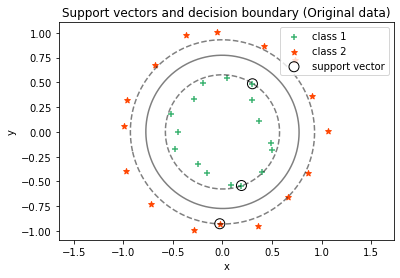

In [31]:
scatter_plot(X, "Support vectors and decision boundary (Original data)", "x", "y", w1=w[0], w2=w[1], w0=w0, hil=np.where(lambdas==1), levels =[-3.25, -2.25, -1.25])

Also the classification map. 

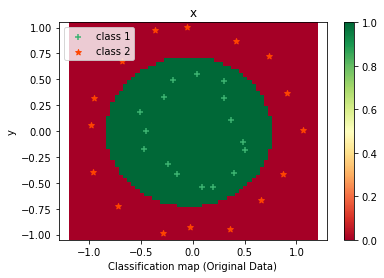

In [33]:
matrix_plot(X, w[0], w[1], w0, 'Classification map (Original Data)', 'y', 'x')

## sklearn 

In [26]:
from sklearn import svm
clf = svm.SVC(C=1e16,kernel='precomputed')
kernel_train = np.dot(X_t, X_t.T)
clf.fit(kernel_train, y.reshape((y.shape[0],)))

SVC(C=1e+16, kernel='precomputed')

In [27]:
clf.support_vectors_

array([], shape=(0, 0), dtype=float64)

In [81]:
h = .02  # step size in the mesh
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])


In [86]:
clf.support_vectors_

array([], shape=(0, 0), dtype=float64)

In [140]:
y.shape

(32, 1)

In [19]:
clf = svm.SVC(C = 1000000, kernel="precomputed")
clf.fit(customKernelGramMatrix(X,X), y)

(32, 32)


/opt/anaconda3/envs/aa-uib/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVC(C=1000000, kernel='precomputed')

In [23]:
h = .02  # step size in the mesh
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])


ValueError: X.shape[1] = 2 should be equal to 32, the number of samples at training time

In [60]:
def gaussianKernelGramMatrixFull(X1, X2):
    """(Pre)calculates Gram Matrix K"""
    gram_matrix = np.zeros((X1.shape[0], X2.shape[0]))
    for i, x in enumerate(X1):
        for j, z in enumerate(X2):
            x = x.flatten()
            z = z.flatten()
            k_result = x[0]*x[1]*z[0]*z[1]
            k_result = k_result + (pow(x[0],2)*pow(z[0],2) + pow(x[0],2)*pow(z[1],2) + pow(x[1],2)*pow(z[0],2) + pow(x[1],2)*pow(z[1],2))
            gram_matrix[i, j] = k_result
    return gram_matrix

C=0.1
clf = svm.SVC(C = C, kernel="precomputed")
model = clf.fit(gaussianKernelGramMatrixFull(X,X),y)

/opt/anaconda3/envs/aa-uib/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [59]:
model.support_vectors_

array([], shape=(0, 0), dtype=float64)

In [57]:
model.coef_[0]

AttributeError: coef_ is only available when using a linear kernel

In [58]:
model.intercept_

array([0.76900803])

In [126]:
clf = svm.SVC(kernel='rbf')
clf.fit(X_t, y.reshape((y.shape[0],)))

SVC()

In [127]:
clf.support_vectors_

array([[ 0.52929287,  1.05872571],
       [ 0.02523657,  0.85938948],
       [ 0.36414085,  0.93388987],
       [ 0.52438972,  1.04884227],
       [-0.43659964,  0.87319994],
       [-0.16150786,  0.32310048],
       [ 0.14675352,  0.32703412],
       [-0.10366835,  0.3293335 ]])

(900, 2)


ValueError: X.shape[1] = 2 should be equal to 32, the number of samples at training time

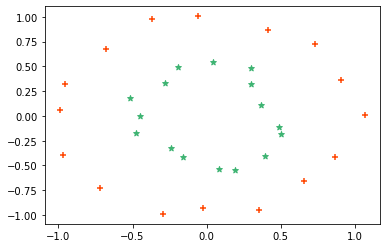

In [128]:
plt.scatter(X[np.where(y < 0)[0]][:,0], X[np.where(y < 0)[0]][:,1], marker='+', color= '#FF4500', label='class 1')
plt.scatter(X[np.where(y > 0)[0]][:,0], X[np.where(y > 0)[0]][:,1], marker='*', color= '#3CB371', label='class 2')
plot_svc_decision_function(model)